# Hubness

Hubs, a subject I find fascinating. A good place to start on this subject is [Hubs in Space: Popular Nearest Neighbors in High-Dimensional Data](https://www.jmlr.org/papers/v11/radovanovic10a.html). In high-dimensional data, when the k-nearest neighbors are calculated, a tendency emerges for a central point to end up being a neighbor of a lot of other points.

Because there are only k x N edges in the nearest neighbor graph, if one point gets more than its fair share of edges, by necessity other items are getting less. So this also leads to the phenomenon of "anti-hubs", friendless items in the neighbor graph that no-one considers a near neighbor. Of course they still have k neighbors, but they don't appear in the neigbor list of anything else.

A likely outcome for dimensionality reduction methods that can be classified as [neighbor embeddings](https://www.jmlr.org/papers/v23/21-0055.html) is that the hub point appears in many edges and hence gets a disproportionate amount of attention, while an increasing proportion of the dataset are anti-hubs which are effectively outliers. If you were to use the nearest neighbor graph as a search graph, you could never find these anti-hubs by walking the graph, so in that sense they aren't representing your data usefully.

None of this seems like it's good for visualization purposes. In reality, how bad is it? Below is some code to calculate the hubness of various datasets, based on the "k-occurrences" of each item. The k-occurrence just counts the number of times each item appears in the k-nearest neighbor list of other items. From a directed graph perspective, you could also say it's the value of the "out-degree" of the item (count the number edges that point to the item). The hubness of a dataset is the maximum value of any k-occurrence in a dataset. An item is an anti-hub if it has a k-occurrence of 0.

Also, unrelated to hubs, but of interest for neighbor embeddings, I include code to calculate if a given nearest neighbor graph contains more than one component. A graph which is not fully connected can cause a spectral embedding to fail and mean you don't have a good "global" view of the data.

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

from drnb.neighbors.hubness import (
    get_nbrs,
    k_occurrences,
    s_occurrences,
)


def hist_occurrences(
    name: str, n_neighbors: int, metric: str = "euclidean", log: bool = False
):
    """Plot histograms and scatter plot of k-occurrences and s-occurrences.

    Parameters
    ----------
    name : str
        Dataset name
    n_neighbors : int
        Number of neighbors used
    metric : str, default="euclidean"
        Distance metric used
    log : bool, default=False
        Whether to use log scale for histograms
    """
    nbrs = get_nbrs(name, n_neighbors, metric=metric)
    ko = k_occurrences(nbrs.idx) / n_neighbors
    so = s_occurrences(nbrs.idx) / n_neighbors
    df = pd.DataFrame(dict(nk_occurrence=ko, ns_occurrence=so))

    fig, axes = plt.subplots(1, 3, figsize=(12, 4))
    fig.tight_layout(pad=2.0)

    fig.suptitle(f"Hubness Analysis: {name} (k={n_neighbors}, {metric})", y=1.05)

    df.hist("nk_occurrence", ax=axes[0], grid=False, log=log)
    axes[0].set_title("k-occurrence Distribution")
    axes[0].set_xlabel("Normalized k-occurrence")
    axes[0].set_ylabel("Count")

    df.hist("ns_occurrence", ax=axes[1], grid=False, log=log)
    axes[1].set_title("s-occurrence Distribution")
    axes[1].set_xlabel("Normalized s-occurrence")
    axes[1].set_ylabel("Count")

    df.plot.scatter(
        "ns_occurrence", "nk_occurrence", ax=axes[2], grid=False, logy=True, alpha=0.5
    )
    axes[2].set_title("k-occurrence vs s-occurrence")

    sns.despine()
    plt.show()

Please be aware that calculating the k-occurrences (and converting to sparse format, needed for the connected component calculation) is done with numba, otherwise it's rather slow, especially for larger values of `n_neighbors`.

## Before we begin: you need to have some data saved

If you want to run this yourself, you should have some actual datasets save to `DRNB_HOME`. See the example notebooks in `data-pipeline` folder for how to do that.

To warm up the numba JIT and to have something to refer to as I go over the columns, let's run the code for two small datasets with a low `n_neighbors`:

In [2]:
from drnb.neighbors.hubness import nbr_stats_summary

In [3]:
hubness15 = nbr_stats_summary(15, names=["iris", "s1k"])
hubness15

,n_items,n_dim,n_comps,dint,kmin,kmedian,kmax,kskew,k#0,nkmax,nkmedian,k#0%,smin,smedian,sskew,s#0,nsmedian,s#0%
iris,150,4,2,3.39,0,15.5,30,0.04,1,2.00,1.03,0.67,0,12.0,-0.68,1,0.80,0.67
s1k,1000,9,1,9.09,0,13.0,69,1.60,9,4.60,0.87,0.90,0,9.0,-0.17,10,0.60,1.00


Here are what all those numbers mean:

* `n_items`: the number of items in the dataset.
* `n_dim`: the number of features (columns) in the dataset.
* `n_comps`: the number of connected components in the neighbor graph.
* `dint`: an estimate of the intrinsic dimensionality of the dataset using the method of [MacKay and Ghahramani](http://www.inference.org.uk/mackay/dimension/), which makes use of the nearest neighbor distances.
* `kmin`, `kmedian`, `kmax`: these are summary statistics of the k-occurrences.
    * `max` is of particular importance because that is the hubness.
    * why is there no `mean`? This is of no interest when it comes to k-occurrences. There are always n_neighbors * N edges in the nearest neighbor graph, so the mean number of k-occurrences will always be n_neighbors.
    * Instead, I have included the median which *is* most definitely of interest.
* `kskew` is the skewness of the k-occurrences, which is used a lot to characterized hubness in datasets by the authors of the "Hubs in Space" paper.
* `k#0`: is the number of items in the dataset with 0 k-occurrence: this is the count of anti-hubs in the dataset.
* `nkmax`: a normalized version of `kmax`, using `n_neighbors` to normalize. If the number of edges in the graph were distributed "fairly" this value would be `1`. While obviously the maximum possible value is controlled by `n_items` rather than `n_neighbors`, using `n_neighbors` gives easier-to-understand number for me it can be interpreted as the number of times more than the "fair share" of edges an item get. Roughly, a value > 10 seems to be when you might be concerned.
* `nkmedian`: the normalized version `kmedian`, normalized by `n_neighbors`, just like `nkmax`.
* `k#0%`: `k#0` as a percentage of the dataset, e.g. this one is normalized by `n_items`. So this is saying what percentage of your dataset are anti-hubs.
* `smin`, `smedian`, `sskew`, `s#0`, `nsmedian`, `s#0%`: these are analogous to the values which have a `k`-prefix instead of an `s` and these measure what I am calling the "s-occurrence" in analogy with "k-occurrence". The s-occurrence counts the symmetric nearest neighbors for an item, i.e. the number of times an item is considered a k-nearest neighbor of its neighbors. 

If you want to visualize the distribution of (normalized) k-occurrences and s-occurrences:

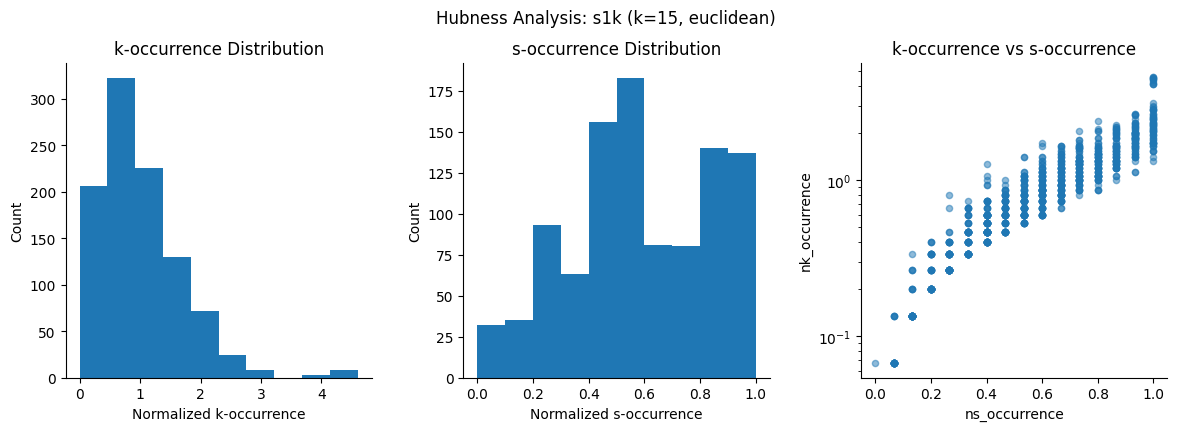

In [4]:
hist_occurrences("s1k", 15)

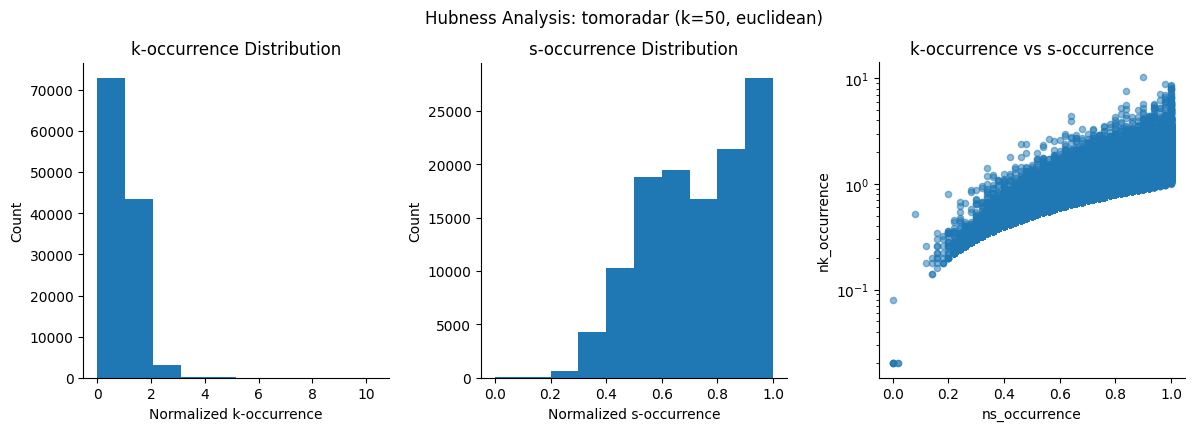

In [5]:
hist_occurrences("tomoradar", 50)

## Datasets

I chose datasets I was reasonably familiar with, a mixture of large, small, high-dimensional and 
low-dimensional, as well as synthetic and real data, including image data and scRNAseq data.

In [6]:
datasets = [
    "avonet",
    "cifar10",
    "coil100",
    "coil20",
    "fashion",
    "frey",
    "gauss10D_10k",
    "gauss2D_10k",
    "gauss3D_10k",
    "gauss50D_10k",
    "gauss50D_1k",
    "gauss5D_10k",
    "iclr",
    "iris",
    "isofaces",
    "isoswiss",
    "kazer",
    "kuzushiji",
    "lamanno2020",
    "lamanno2020-pca50",
    "macosko2015",
    "macosko2015-pca50",
    "mammoth",
    "mnist",
    "ng20",
    "norb",
    "olivetti",
    "olivetti92x112",
    "onet271",
    "penguins",
    "s1k",
    "scurvehole",
    "spheres",
    "synthetic-hierarchical",
    "tasic2018",
    "tasic2018-pca50",
    "tomoradar",
]
len(datasets)


37

## 15 neighbors

So let's look at the 15-neighbor result for some datasets. `n_neighbors=15` is typical for UMAP results.

In [7]:
hubness15 = nbr_stats_summary(n_neighbors=15, names=datasets)
hubness15

,n_items,n_dim,n_comps,dint,kmin,kmedian,kmax,kskew,k#0,nkmax,nkmedian,k#0%,smin,smedian,sskew,s#0,nsmedian,s#0%
avonet,11009,11,1,4.71,0,15.0,44,0.33,39,2.93,1.00,0.35,0,10.0,-0.45,75,0.67,0.68
cifar10,60000,3072,1,34.81,0,2.0,2005,9.52,18689,133.67,0.13,31.15,0,0.0,3.07,36930,0.00,61.55
coil100,7200,49152,13,4.61,1,14.0,67,1.40,0,4.47,0.93,0.00,0,12.0,-0.73,2,0.80,0.03
coil20,1440,16384,3,4.77,2,14.0,52,1.08,0,3.47,0.93,0.00,2,12.0,-0.78,0,0.80,0.00
fashion,70000,784,1,17.98,0,10.0,267,2.72,6728,17.80,0.67,9.61,0,5.0,0.41,10296,0.33,14.71
frey,1965,560,1,6.91,0,14.0,45,0.66,6,3.00,0.93,0.31,0,10.0,-0.31,11,0.67,0.56
gauss10D_10k,10000,10,1,11.46,0,14.0,45,0.42,129,3.00,0.93,1.29,0,8.0,-0.06,166,0.53,1.66
gauss2D_10k,10000,2,1,2.43,1,15.0,24,-0.17,0,1.60,1.00,0.00,1,13.0,-1.31,0,0.87,0.00
gauss3D_10k,10000,3,1,3.68,0,15.0,26,-0.40,5,1.73,1.00,0.05,0,13.0,-1.22,6,0.87,0.06
gauss50D_10k,10000,50,1,37.71,0,6.0,566,5.75,1235,37.73,0.40,12.35,0,3.0,0.90,1568,0.20,15.68


A lot going on here. To get a grip, let's look at what I consider low-dimensional datasets, those with less than 100 dimensions in the initial data:

In [8]:
hubness15.loc[hubness15["n_dim"] < 100]

,n_items,n_dim,n_comps,dint,kmin,kmedian,kmax,kskew,k#0,nkmax,nkmedian,k#0%,smin,smedian,sskew,s#0,nsmedian,s#0%
avonet,11009,11,1,4.71,0,15.0,44,0.33,39,2.93,1.00,0.35,0,10.0,-0.45,75,0.67,0.68
gauss10D_10k,10000,10,1,11.46,0,14.0,45,0.42,129,3.00,0.93,1.29,0,8.0,-0.06,166,0.53,1.66
gauss2D_10k,10000,2,1,2.43,1,15.0,24,-0.17,0,1.60,1.00,0.00,1,13.0,-1.31,0,0.87,0.00
gauss3D_10k,10000,3,1,3.68,0,15.0,26,-0.40,5,1.73,1.00,0.05,0,13.0,-1.22,6,0.87,0.06
gauss50D_10k,10000,50,1,37.71,0,6.0,566,5.75,1235,37.73,0.40,12.35,0,3.0,0.90,1568,0.20,15.68
gauss50D_1k,1000,50,1,32.41,0,8.0,345,5.55,67,23.00,0.53,6.70,0,5.0,0.46,79,0.33,7.90
gauss5D_10k,10000,5,1,6.16,0,15.0,30,-0.50,24,2.00,1.00,0.24,0,11.0,-0.72,28,0.73,0.28
iris,150,4,2,3.39,0,15.5,30,0.04,1,2.00,1.03,0.67,0,12.0,-0.68,1,0.80,0.67
isoswiss,20000,3,1,2.41,3,15.0,27,0.01,0,1.80,1.00,0.00,3,14.0,-1.09,0,0.93,0.00
kazer,59286,70,1,30.40,0,8.0,433,4.11,5343,28.87,0.53,9.01,0,3.0,0.95,10083,0.20,17.01


Most of these datasets are pretty well-behaved, with the exception of `macosko2015`, which even in its PCA-reduced forms (Z-scaled or not), tends to form hubs. But for the others, the hubness is quite low. What about high-dimensional datasets? For this, I define high-dimensional as > 1000 dimensions.

In [9]:
hubness15.loc[hubness15["n_dim"] >= 1000]

,n_items,n_dim,n_comps,dint,kmin,kmedian,kmax,kskew,k#0,nkmax,nkmedian,k#0%,smin,smedian,sskew,s#0,nsmedian,s#0%
cifar10,60000,3072,1,34.81,0,2.0,2005,9.52,18689,133.67,0.13,31.15,0,0.0,3.07,36930,0.00,61.55
coil100,7200,49152,13,4.61,1,14.0,67,1.40,0,4.47,0.93,0.00,0,12.0,-0.73,2,0.80,0.03
coil20,1440,16384,3,4.77,2,14.0,52,1.08,0,3.47,0.93,0.00,2,12.0,-0.78,0,0.80,0.00
iclr,14732,3000,1,69.60,0,5.0,9023,51.43,1764,601.53,0.33,11.97,0,3.0,0.93,2280,0.20,15.48
isofaces,698,4096,1,4.70,2,15.0,30,0.29,0,2.00,1.00,0.00,2,12.0,-0.69,0,0.80,0.00
lamanno2020,3850,1999,1,51.26,0,9.0,169,2.28,387,11.27,0.60,10.05,0,4.0,0.59,631,0.27,16.39
macosko2015,44808,3000,1,112.48,0,1.0,10542,36.61,20450,702.80,0.07,45.64,0,0.0,5.83,39658,0.00,88.51
ng20,18846,3000,1,20.98,0,4.0,8351,33.46,2117,556.73,0.27,11.23,0,1.0,1.91,6338,0.07,33.63
norb,48600,9216,2,6.74,0,13.0,156,2.65,1,10.40,0.87,0.00,0,9.0,-0.03,16,0.60,0.03
olivetti,400,4096,1,9.53,1,11.0,95,1.85,0,6.33,0.73,0.00,1,8.0,0.09,0,0.53,0.00


Compared to the low-dimensional datasets, these datasets are much more prone to hubness. `macosko2015` is particularly bad, but `tasic2018` (also an scRNAseq dataset), `ng20` (a document dataset) and `cifar10` (an image dataset) are also bad. Also `lamanno2020` (yep, another scRNAseq dataset) is a bit concerning because 10% of the data are anti-hubs. On other hand, `coil20`, `coil100` and `olivetti92x112`, despite being very high-dimensional, don't show that bad a behavior, so simply having a large number of columns isn't enough to indicate hubness. 

## 50 neighbors

In [10]:
hubness50 = nbr_stats_summary(n_neighbors=50, names=datasets)
hubness50

,n_items,n_dim,n_comps,dint,kmin,kmedian,kmax,kskew,k#0,nkmax,nkmedian,k#0%,smin,smedian,sskew,s#0,nsmedian,s#0%
avonet,11009,11,1,4.69,0,49.0,125,0.22,9,2.50,0.98,0.08,0,34.0,-0.47,10,0.68,0.09
cifar10,60000,3072,1,28.32,0,8.0,4261,7.52,10114,85.22,0.16,16.86,0,1.0,2.94,24051,0.02,40.09
coil100,7200,49152,5,5.47,2,44.0,295,1.75,0,5.90,0.88,0.00,1,31.0,-0.16,0,0.62,0.00
coil20,1440,16384,2,4.99,4,44.0,158,0.90,0,3.16,0.88,0.00,3,35.0,-0.34,0,0.70,0.00
fashion,70000,784,1,14.86,0,37.0,759,2.34,3165,15.18,0.74,4.52,0,19.0,0.26,4722,0.38,6.75
frey,1965,560,1,6.45,0,46.0,176,0.88,1,3.52,0.92,0.05,0,32.0,-0.32,1,0.64,0.05
gauss10D_10k,10000,10,1,10.02,0,44.0,165,0.68,23,3.30,0.88,0.23,0,26.0,-0.07,25,0.52,0.25
gauss2D_10k,10000,2,1,2.18,3,50.0,69,-1.60,0,1.38,1.00,0.00,3,46.0,-2.27,0,0.92,0.00
gauss3D_10k,10000,3,1,3.29,1,51.0,73,-1.69,0,1.46,1.02,0.00,1,43.0,-1.51,0,0.86,0.00
gauss50D_10k,10000,50,1,31.29,0,22.0,1434,4.88,299,28.68,0.44,2.99,0,13.0,0.75,335,0.26,3.35


In [11]:
hubness50.loc[hubness50["n_dim"] < 100]

,n_items,n_dim,n_comps,dint,kmin,kmedian,kmax,kskew,k#0,nkmax,nkmedian,k#0%,smin,smedian,sskew,s#0,nsmedian,s#0%
avonet,11009,11,1,4.69,0,49.0,125,0.22,9,2.50,0.98,0.08,0,34.0,-0.47,10,0.68,0.09
gauss10D_10k,10000,10,1,10.02,0,44.0,165,0.68,23,3.30,0.88,0.23,0,26.0,-0.07,25,0.52,0.25
gauss2D_10k,10000,2,1,2.18,3,50.0,69,-1.60,0,1.38,1.00,0.00,3,46.0,-2.27,0,0.92,0.00
gauss3D_10k,10000,3,1,3.29,1,51.0,73,-1.69,0,1.46,1.02,0.00,1,43.0,-1.51,0,0.86,0.00
gauss50D_10k,10000,50,1,31.29,0,22.0,1434,4.88,299,28.68,0.44,2.99,0,13.0,0.75,335,0.26,3.35
gauss50D_1k,1000,50,1,25.60,0,33.0,648,2.97,9,12.96,0.66,0.90,0,22.0,0.17,9,0.44,0.90
gauss5D_10k,10000,5,1,5.42,0,55.0,85,-0.87,5,1.70,1.10,0.05,0,36.0,-0.76,5,0.72,0.05
iris,150,4,1,1.45,12,49.0,95,0.21,0,1.90,0.98,0.00,12,48.0,-1.46,0,0.96,0.00
isoswiss,20000,3,1,2.13,21,50.0,78,-0.32,0,1.56,1.00,0.00,21,47.0,-1.96,0,0.94,0.00
kazer,59286,70,1,24.23,0,28.0,1324,3.72,1189,26.48,0.56,2.01,0,12.0,0.80,2334,0.24,3.94


In [12]:
hubness50.loc[hubness50["n_dim"] >= 1000]

,n_items,n_dim,n_comps,dint,kmin,kmedian,kmax,kskew,k#0,nkmax,nkmedian,k#0%,smin,smedian,sskew,s#0,nsmedian,s#0%
cifar10,60000,3072,1,28.32,0,8.0,4261,7.52,10114,85.22,0.16,16.86,0,1.0,2.94,24051,0.02,40.09
coil100,7200,49152,5,5.47,2,44.0,295,1.75,0,5.90,0.88,0.00,1,31.0,-0.16,0,0.62,0.00
coil20,1440,16384,2,4.99,4,44.0,158,0.90,0,3.16,0.88,0.00,3,35.0,-0.34,0,0.70,0.00
iclr,14732,3000,1,65.97,0,15.0,13904,27.40,476,278.08,0.30,3.23,0,10.0,1.10,607,0.20,4.12
isofaces,698,4096,1,5.21,7,48.0,113,0.46,0,2.26,0.96,0.00,4,37.0,-0.37,0,0.74,0.00
lamanno2020,3850,1999,1,36.38,0,36.0,466,1.99,85,9.32,0.72,2.21,0,21.0,0.21,119,0.42,3.09
macosko2015,44808,3000,1,89.98,0,4.0,18582,24.91,11609,371.64,0.08,25.91,0,0.0,5.00,35291,0.00,78.76
ng20,18846,3000,1,33.76,0,6.0,16017,18.92,1693,320.34,0.12,8.98,0,1.0,4.67,5639,0.02,29.92
norb,48600,9216,2,9.76,1,37.0,744,2.82,0,14.88,0.74,0.00,0,22.0,0.33,2,0.44,0.00
olivetti,400,4096,1,10.11,2,39.0,251,1.47,0,5.02,0.78,0.00,2,26.5,0.02,0,0.53,0.00


## 150 neighbors

In [13]:
hubness150 = nbr_stats_summary(n_neighbors=150, names=datasets)
hubness150

,n_items,n_dim,n_comps,dint,kmin,kmedian,kmax,kskew,k#0,nkmax,nkmedian,k#0%,smin,smedian,sskew,s#0,nsmedian,s#0%
avonet,11009,11,1,4.53,0,146.0,375,0.25,1,2.50,0.97,0.01,0,98.0,-0.43,1,0.65,0.01
cifar10,60000,3072,1,24.04,0,29.0,7902,6.02,4623,52.68,0.19,7.71,0,5.0,2.50,12680,0.03,21.13
coil100,7200,49152,1,4.49,2,111.0,1119,2.32,0,7.46,0.74,0.00,2,80.0,0.01,0,0.53,0.00
coil20,1440,16384,1,4.27,4,113.0,584,1.35,0,3.89,0.75,0.00,4,82.0,0.14,0,0.55,0.00
fashion,70000,784,1,12.94,0,117.0,1772,1.93,1601,11.81,0.78,2.29,0,67.0,0.11,2262,0.45,3.23
frey,1965,560,1,6.39,2,138.0,434,0.64,0,2.89,0.92,0.00,2,89.0,-0.09,0,0.59,0.00
gauss10D_10k,10000,10,1,9.21,0,126.0,617,1.01,3,4.11,0.84,0.03,0,79.0,-0.05,3,0.53,0.03
gauss2D_10k,10000,2,1,2.09,5,154.0,185,-3.05,0,1.23,1.03,0.00,5,137.0,-2.14,0,0.91,0.00
gauss3D_10k,10000,3,1,3.15,2,162.0,203,-1.85,0,1.35,1.08,0.00,2,124.0,-1.30,0,0.83,0.00
gauss50D_10k,10000,50,1,27.60,0,75.0,3198,3.90,55,21.32,0.50,0.55,0,47.0,0.58,57,0.31,0.57


## NG20 Euclidean vs Cosine

The `ng20` dataset is a document dataset. In its form here it's a 3000-dimension PCA dense vector representation of the original sparse TDF-IF data. We would expect that the cosine metric would be a better choice for this dataset and with the Euclidean metric, is does seem like there is a lot of hubness going on with 15 nearest neighbors:

In [14]:
nbr_stats_summary(15, names=["ng20", "iclr"], metric="euclidean")

,n_items,n_dim,n_comps,dint,kmin,kmedian,kmax,kskew,k#0,nkmax,nkmedian,k#0%,smin,smedian,sskew,s#0,nsmedian,s#0%
ng20,18846,3000,1,20.98,0,4.0,8351,33.46,2117,556.73,0.27,11.23,0,1.0,1.91,6338,0.07,33.63
iclr,14732,3000,1,69.60,0,5.0,9023,51.43,1764,601.53,0.33,11.97,0,3.0,0.93,2280,0.20,15.48


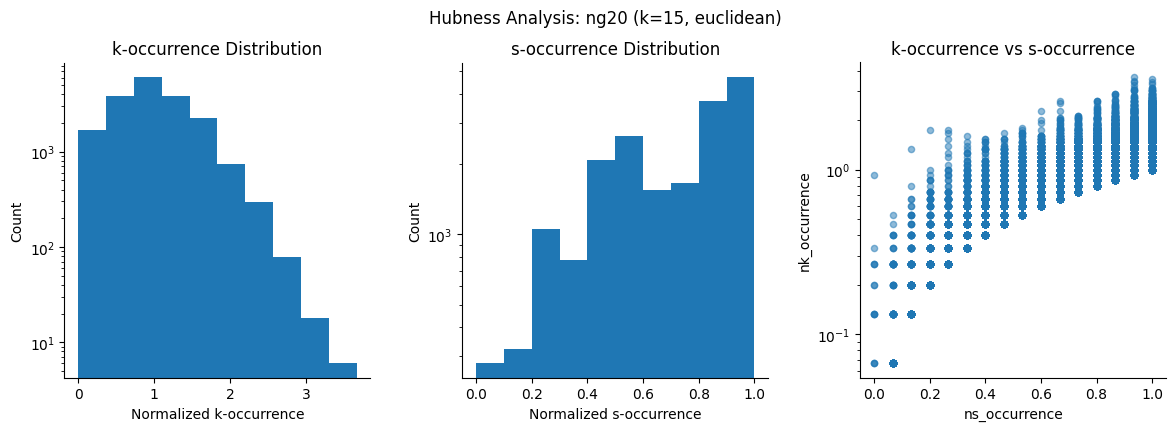

In [15]:
hist_occurrences("ng20", 15, log=True)

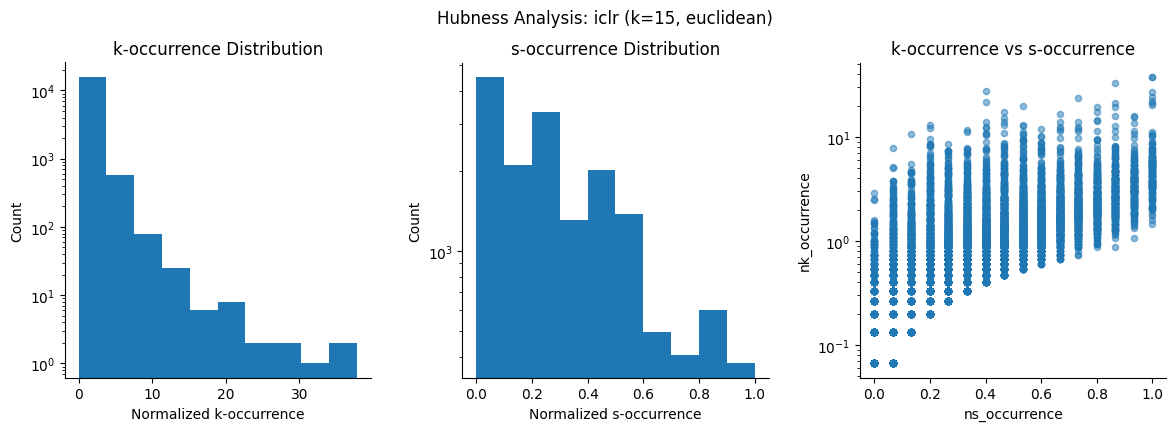

In [16]:
hist_occurrences("iclr", 15, log=True)

Does switching to the cosine metric help:

In [17]:
nbr_stats_summary(15, names=["ng20", "iclr"], metric="cosine")

,n_items,n_dim,n_comps,dint,kmin,kmedian,kmax,kskew,k#0,nkmax,nkmedian,k#0%,smin,smedian,sskew,s#0,nsmedian,s#0%
ng20,18846,3000,1,-4.84,0,11.0,2184,37.73,105,145.60,0.73,0.56,0,8.0,0.09,455,0.53,2.41
iclr,14732,3000,1,-10.11,0,12.0,165,2.11,126,11.00,0.80,0.86,0,8.0,0.00,203,0.53,1.38


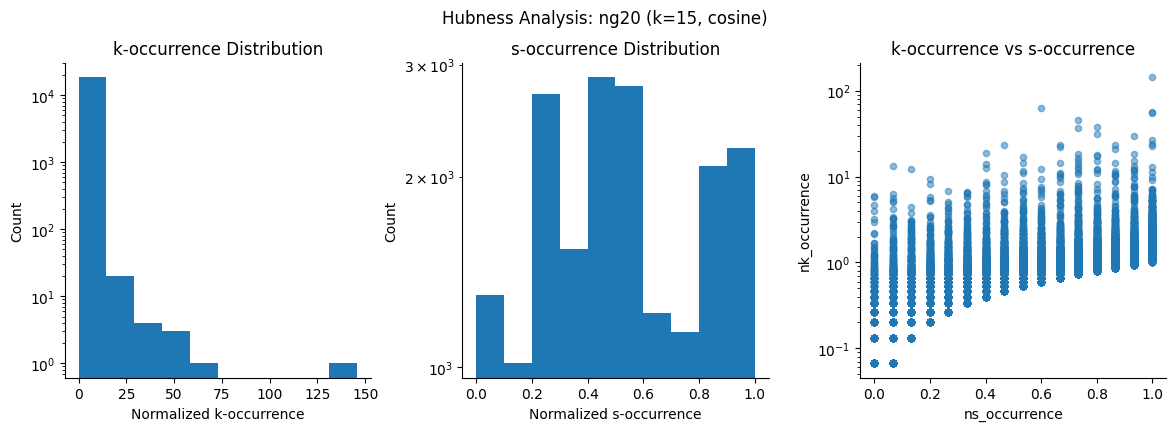

In [18]:
hist_occurrences("ng20", 15, metric="cosine", log=True)

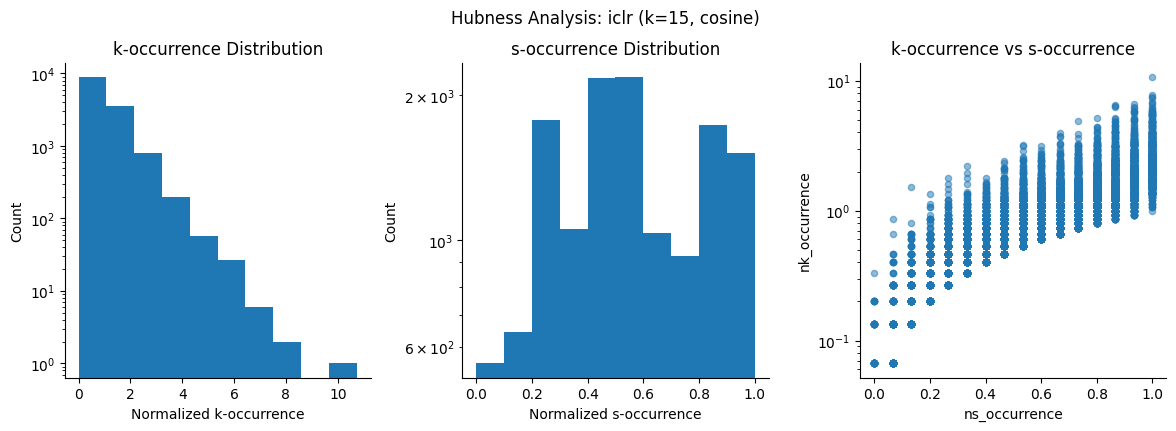

In [19]:
hist_occurrences("iclr", 15, metric="cosine", log=True)

Although the skew is larger for `cosine` k-occurrrence, the other metrics (e.g. maximum, median and number of anti-hubs) all show an improvement. The s-occurrences is also obviously better.

Here are the results for 150 neighbors:

In [20]:
nbr_stats_summary(150, names=["ng20", "iclr"], metric="euclidean")

,n_items,n_dim,n_comps,dint,kmin,kmedian,kmax,kskew,k#0,nkmax,nkmedian,k#0%,smin,smedian,sskew,s#0,nsmedian,s#0%
ng20,18846,3000,1,40.19,0,7.0,18802,11.43,1494,125.35,0.05,7.93,0,2.0,6.68,5002,0.01,26.54
iclr,14732,3000,1,67.44,0,38.0,14726,13.70,91,98.17,0.25,0.62,0,25.0,1.39,105,0.17,0.71


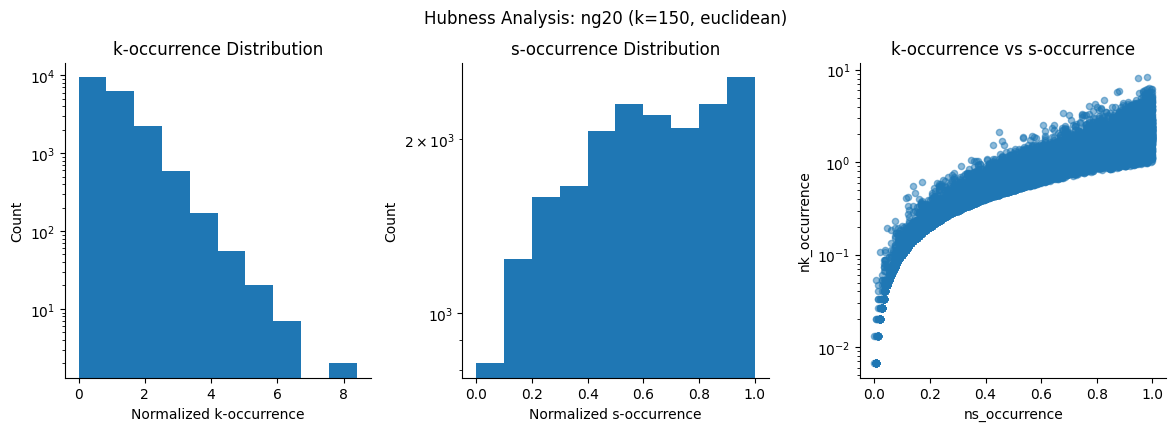

In [21]:
hist_occurrences("ng20", 150, log=True)

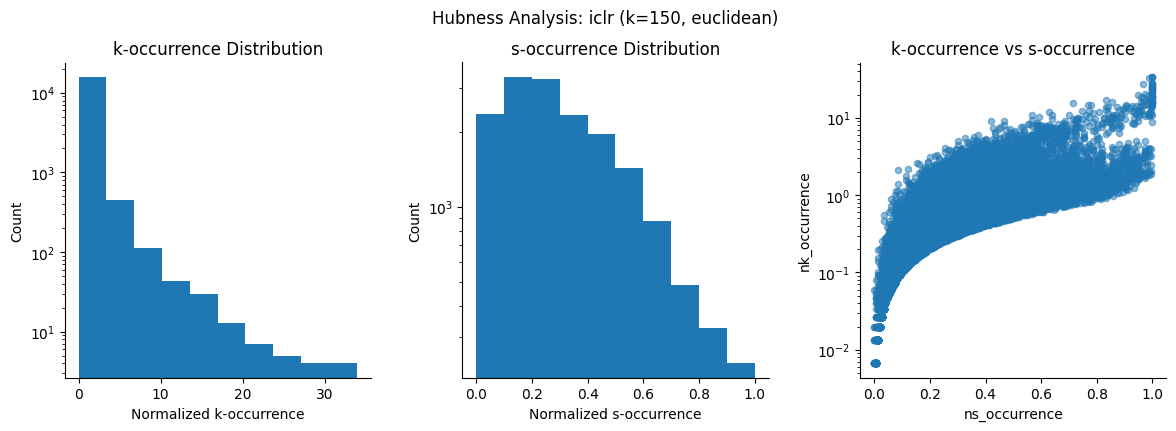

In [22]:
hist_occurrences("iclr", 150, log=True)

In [23]:
nbr_stats_summary(150, names=["ng20", "iclr"], metric="cosine")

,n_items,n_dim,n_comps,dint,kmin,kmedian,kmax,kskew,k#0,nkmax,nkmedian,k#0%,smin,smedian,sskew,s#0,nsmedian,s#0%
ng20,18846,3000,1,-4.76,0,76.0,12882,12.54,2,85.88,0.51,0.01,0,36.0,1.15,18,0.24,0.10
iclr,14732,3000,1,-6.75,6,128.0,915,1.71,0,6.10,0.85,0.00,6,97.0,-0.28,0,0.65,0.00


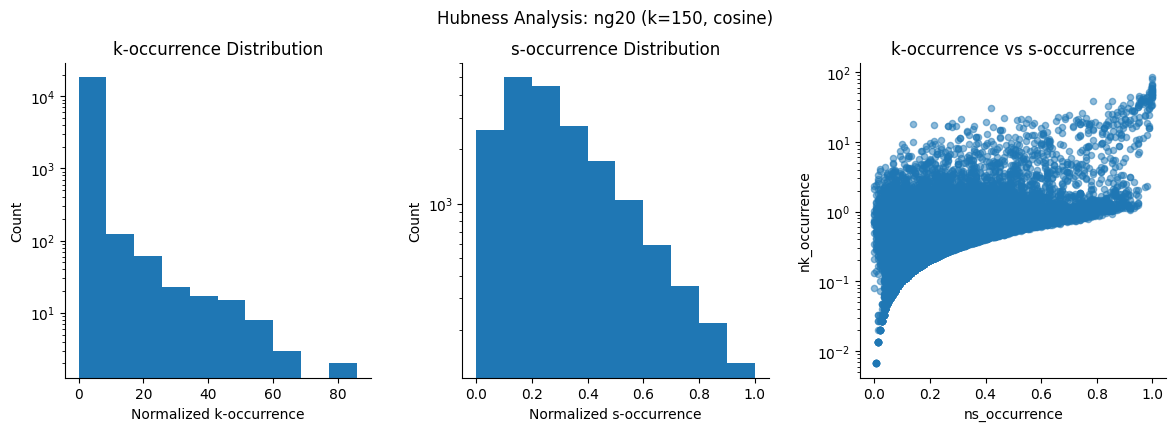

In [24]:
hist_occurrences("ng20", 150, metric="cosine", log=True)

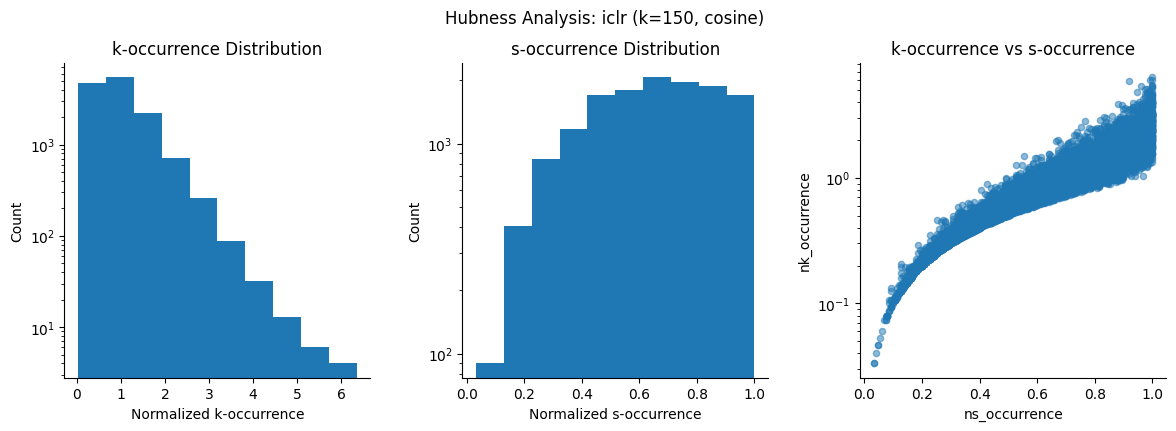

In [25]:
hist_occurrences("iclr", 150, metric="cosine", log=True)

Again the cosine metric seems to do better in terms of hubness.